#Sales Analysis Project in Spark

In [ ]:
# import required pyspark SQL data types for defining schema
from pyspark.sql.types import *
from pyspark.sql import SparkSession
# Define a schema (structure) for the sales data with columns names and types
schema = StructType([
    StructField("product_id",IntegerType(),True),
    StructField("customer_id",StringType(),True),
    StructField("order_data",DateType(),True),
    StructField("location",StringType(),True),
    StructField("source_order",StringType(),True)

])





In [ ]:
# create spark session
spark = SparkSession.builder.appName("sales_analysis").getOrCreate()


In [ ]:
# read the sales data from a csv file into DataFrame
sales_df = spark.read.format("csv").option("inferschema","true").schema(schema).load("sales.csv.txt")

sales_df.show()

+----------+-----------+----------+--------+------------+
|product_id|customer_id|order_data|location|source_order|
+----------+-----------+----------+--------+------------+
|         1|          A|2023-01-01|   India|      Swiggy|
|         2|          A|2022-01-01|   India|      Swiggy|
|         2|          A|2023-01-07|   India|      Swiggy|
|         3|          A|2023-01-10|   India|  Restaurant|
|         3|          A|2022-01-11|   India|      Swiggy|
|         3|          A|2023-01-11|   India|  Restaurant|
|         2|          B|2022-02-01|   India|      Swiggy|
|         2|          B|2023-01-02|   India|      Swiggy|
|         1|          B|2023-01-04|   India|  Restaurant|
|         1|          B|2023-02-11|   India|      Swiggy|
|         3|          B|2023-01-16|   India|      zomato|
|         3|          B|2022-02-01|   India|      zomato|
|         3|          C|2023-01-01|   India|      zomato|
|         1|          C|2023-01-01|      UK|      Swiggy|
|         6|  

In [ ]:
# shape of data
shape = (sales_df.count(),len(sales_df.columns))
shape

(117, 5)

In [ ]:
# derive yearly,monthly and quarterly sales
from pyspark.sql.functions import month,year,quarter

sales_df = sales_df.withColumn("order_year",year(sales_df.order_data))
sales_df = sales_df.withColumn("order_month",month(sales_df.order_data))
sales_df = sales_df.withColumn("order_quarter",quarter(sales_df.order_data))

sales_df.show()


+----------+-----------+----------+--------+------------+----------+-----------+-------------+
|product_id|customer_id|order_data|location|source_order|order_year|order_month|order_quarter|
+----------+-----------+----------+--------+------------+----------+-----------+-------------+
|         1|          A|2023-01-01|   India|      Swiggy|      2023|          1|            1|
|         2|          A|2022-01-01|   India|      Swiggy|      2022|          1|            1|
|         2|          A|2023-01-07|   India|      Swiggy|      2023|          1|            1|
|         3|          A|2023-01-10|   India|  Restaurant|      2023|          1|            1|
|         3|          A|2022-01-11|   India|      Swiggy|      2022|          1|            1|
|         3|          A|2023-01-11|   India|  Restaurant|      2023|          1|            1|
|         2|          B|2022-02-01|   India|      Swiggy|      2022|          2|            1|
|         2|          B|2023-01-02|   India|      

create a dataframe for menu.csv dataset

In [ ]:
schema_menu = StructType(
    [
       StructField("product_id",IntegerType(),True),
       StructField("product_name",StringType(),True),
       StructField("price",DoubleType(),True)
    ]
)

menu_df = spark.read.format("csv").schema(schema_menu).load(r"menu.csv.txt")
menu_df.show()

+----------+------------+-----+
|product_id|product_name|price|
+----------+------------+-----+
|         1|       PIZZA|100.0|
|         2|     Chowmin|150.0|
|         3|    sandwich|120.0|
|         4|        Dosa|110.0|
|         5|     Biryani| 80.0|
|         6|       Pasta|180.0|
+----------+------------+-----+



Analysis

In [ ]:
# Total amount spent by each customer
total_by_customer = sales_df.join(menu_df,"product_id").groupBy("Customer_id").agg({"price":"sum"}).orderBy("Customer_id")

total_by_customer.show()

+-----------+----------+
|Customer_id|sum(price)|
+-----------+----------+
|          A|    4260.0|
|          B|    4440.0|
|          C|    2400.0|
|          D|    1200.0|
|          E|    2040.0|
+-----------+----------+



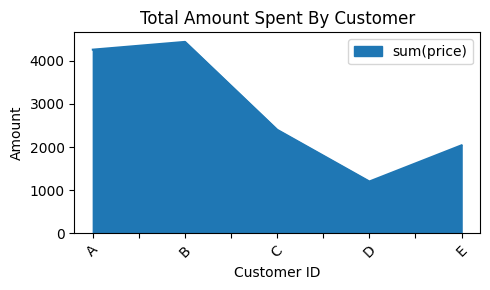

In [ ]:
# plot total amount spent by each customer
import matplotlib.pyplot as plt

total_by_customer_pd  =total_by_customer.toPandas()
total_by_customer_pd.plot(kind="area",x='Customer_id',y='sum(price)',figsize=(5,3))

plt.title("Total Amount Spent By Customer")
plt.xlabel("Customer ID")
plt.ylabel("Amount")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Total amount spent in each food category
total_by_food_category = sales_df.join(menu_df,"Product_id").groupBy("Product_name").agg({"price":"sum"}).orderBy("Product_name")
total_by_food_category.show()

+------------+----------+
|Product_name|sum(price)|
+------------+----------+
|     Biryani|     480.0|
|     Chowmin|    3600.0|
|        Dosa|    1320.0|
|       PIZZA|    2100.0|
|       Pasta|    1080.0|
|    sandwich|    5760.0|
+------------+----------+



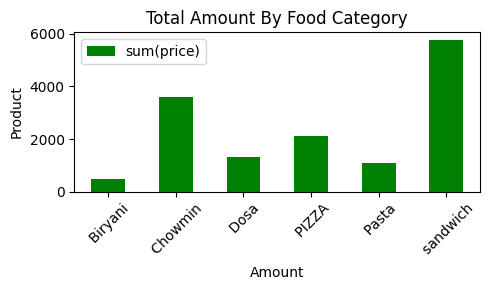

In [ ]:
# plot total amount spent by food category
total_by_food_category_pd = total_by_food_category.toPandas()
total_by_food_category_pd.plot(kind='bar',x='Product_name',y='sum(price)',figsize=(5,3),color='green')

plt.title('Total Amount By Food Category')
plt.xlabel('Amount')
plt.ylabel("Product")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# monthly sales
total_amount_by_month = sales_df.join(menu_df,"product_id").groupBy("order_month").agg({"price":"sum"}).orderBy("order_month")
total_amount_by_month.show()


+-----------+----------+
|order_month|sum(price)|
+-----------+----------+
|          1|    2960.0|
|          2|    2730.0|
|          3|     910.0|
|          5|    2960.0|
|          6|    2960.0|
|          7|     910.0|
|         11|     910.0|
+-----------+----------+



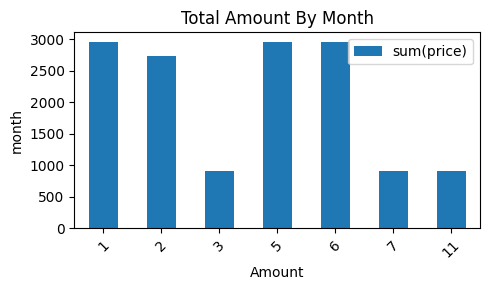

In [ ]:
# plot monthly data
total_amount_by_month_pd = total_amount_by_month.toPandas()
total_amount_by_month_pd.plot(kind="bar",x="order_month",y='sum(price)',figsize=(5,3))

plt.title('Total Amount By Month')
plt.xlabel('Amount')
plt.ylabel('month')
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# yearly sales
total_amount_by_year = sales_df.join(menu_df,"product_id").groupBy("order_year").agg({"price":"sum"}).orderBy("order_year")
total_amount_by_year.show()

+----------+----------+
|order_year|sum(price)|
+----------+----------+
|      2022|    4350.0|
|      2023|    9990.0|
+----------+----------+



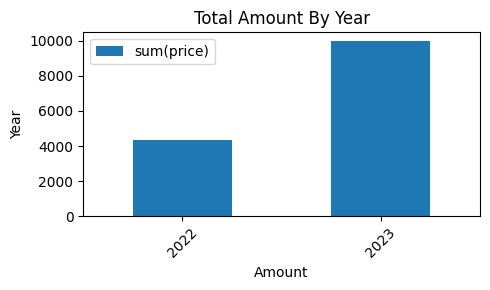

In [ ]:
# plot Yearly data
total_amount_by_year_pd = total_amount_by_year.toPandas()
total_amount_by_year_pd.plot(kind="bar",x="order_year",y='sum(price)',figsize=(5,3))

plt.title('Total Amount By Year')
plt.xlabel('Amount')
plt.ylabel('Year')
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Quarterly Sales
total_amount_by_quarter = sales_df.join(menu_df,"product_id").groupBy("order_quarter").agg({"price":"sum"}).orderBy("order_quarter")
total_amount_by_quarter.show()

+-------------+----------+
|order_quarter|sum(price)|
+-------------+----------+
|            1|    6600.0|
|            2|    5920.0|
|            3|     910.0|
|            4|     910.0|
+-------------+----------+



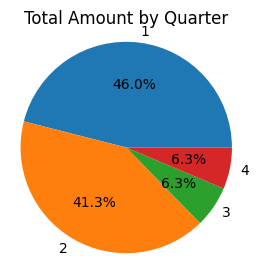

In [ ]:
# pie chart for quarterly sales
total_amount_by_quarter_pd = total_amount_by_quarter.toPandas()

# plotting pie chart
plt.figure(figsize=(3,3))
plt.pie(total_amount_by_quarter_pd['sum(price)'],labels=total_amount_by_quarter_pd['order_quarter'], autopct='%1.1f%%')
plt.title('Total Amount by Quarter')
plt.axis('equal')
plt.show()

In [ ]:
# Total number of orders in each category
from pyspark.sql.functions import *
total_order = sales_df.join(menu_df,"product_id").groupBy("product_name").agg(count("product_id").alias('product_count')).orderBy('product_count',ascending=0)
total_order.show()

+------------+-------------+
|product_name|product_count|
+------------+-------------+
|    sandwich|           48|
|     Chowmin|           24|
|       PIZZA|           21|
|        Dosa|           12|
|       Pasta|            6|
|     Biryani|            6|
+------------+-------------+



In [ ]:
# top 5 ordered items
top_5 = total_order.limit(5)
top_5.show()

+------------+-------------+
|product_name|product_count|
+------------+-------------+
|    sandwich|           48|
|     Chowmin|           24|
|       PIZZA|           21|
|        Dosa|           12|
|       Pasta|            6|
+------------+-------------+



In [ ]:
# Frequaency of customer's visits



frequency = sales_df.filter(sales_df.source_order=='Restaurant').groupBy('customer_id').agg(countDistinct('order_data').alias('number_of_visits')).orderBy('number_of_visits')

frequency.show()


+-----------+----------------+
|customer_id|number_of_visits|
+-----------+----------------+
|          D|               1|
|          C|               3|
|          E|               5|
|          B|               6|
|          A|               6|
+-----------+----------------+



In [ ]:
# Total sales by location
total_by_location = sales_df.join(menu_df,'product_id').groupBy("Location").agg({"price":"sum"}).orderBy('sum(price)',ascending=0)

total_by_location.show()

+--------+----------+
|Location|sum(price)|
+--------+----------+
|      UK|    7020.0|
|   India|    4860.0|
|     USA|    2460.0|
+--------+----------+



In [ ]:
# Total sales by order source
total_by_source = sales_df.join(menu_df,"product_id").groupBy('Source_order').agg({"price":"sum"}).orderBy('sum(price)',ascending=0)
total_by_source.show()

+------------+----------+
|Source_order|sum(price)|
+------------+----------+
|      Swiggy|    6330.0|
|      zomato|    4920.0|
|  Restaurant|    3090.0|
+------------+----------+

